# PHYS20762 - Project 2

Dominik Szablonski <br>
11310146 <br>
University of Manchester <br>
March 2025

We first initialise our interpreter.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider, FloatLogSlider
from scipy.signal import find_peaks
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 14})
plt.style.use('default')

Our equation of motion is,

$$mx''(t) + bx'(t) + kx(t) = F(t)$$

where $k = 1.87$kg s$^{-2}$ and $m = 4.01$kg. 

Most of the other constants we can vary throughout the notebook using sliders, however in some cases we are not concerned with varying certain parameters. So, we will define global values for these parameters. We will choose to set a global damping constant $b = \frac{1}{10} b_{cr}$, where $b_{cr}$ is the critical damping value, which is given by,

$$b_{cr}^2 = 4km.$$

Critical damping is discussed further on in the notebook, but for now let us say that the critical damping value is the one which results in the system returning to equilibrium in the shortest amount of time.

Our system will have a natural frequency, $\omega_0$, given by,

$$\omega_0 = \sqrt{\frac{k}{m}}$$

which is the frequency of the oscillator if it were to not experience any damping or forcing.

We will finally set our initial values for the system, i.e., its state at $t=0$. We will be denoting $x(0) = x_0$ and $v(0) = v_0$.

In [2]:
K = 1.87 # kg / s^2
M = 4.01 # kg
B_CRIT = np.sqrt(4*K*M) # kg s^-1
B = 0.1*B_CRIT # kg s^-1
NATURAL_FREQUENCY = np.sqrt(K/M) #s^-1
X_0 = 1 # m
V_0 = 0 # m s^-1

We will now initialise parameters which will effect our simulations, i.e., the simulation time and step size. From these, the number of steps to run each simulation can be calculated, alongside a default time array for when we perform plotting procedures.

In [3]:
TIME = 100 # s
STEP = 1e-3
STEPS = int(TIME/STEP)
TIME_ARRAY = np.linspace(0, TIME, num=STEPS)

We will now begin to attempt to solve the equation above, first by assuming $F(t) = 0$. However, when deriving the numerical methods, we will include a force term so that we can use them later. 

**NOTE:** The application of force is only supported for Verlet, given that that was the method which was used at the end of the project. However, in the derivation of each numerical method, force terms are included for completion.

# Euler Method
For the euler method, let us write our equation of motion,

$$x'' + \frac{b}{m}x' + \frac{k}{m}x = \frac{1}{m}F(t)$$

and let us define $v = x'$ and $a = x''$. If we consider the definition of the derivative,

$$v(t) = \lim_{h \to 0} \frac{x(t + h) - x(t)}{h},$$

we can get rid of the limit and say that for a given step $h$, the definiton above is an approximation of the derivative such that,

$$v(t) = \frac{x(t + h) - x(t)}{h} + \text{error}.$$

By rearranging, and applying this to the second derivative (i.e., acceleration), we have,

$$x_{i+1} = x_i + hv_{i} + \mathcal{O}(h^2)$$
$$v_{i+1} = v_i + ha_i + \mathcal{O}(h^2)$$
$$a_i = -\frac{b}{m}v_i - \frac{k}{m}x_i + \frac{1}{m}F_i$$

where $i$ denotes the $i$th step of the simulationm and $\mathcal{O}(h^2)$ is the *local truncation error*, which is the error of the next step, given a known previous step. The simulation will also have a *global truncation error*, which is the accumulation of error over all steps of the simulation. It can be easily determined by seeing that the number of steps taken in the simulation is given by $\frac{t_N}{h}$, where $t_N$ is the time at which the simulation ends, given that the simulation starts at $t=0$. Since the local truncation error is of order $h^2$, the global truncation error will be $\mathcal{O}(h)$, for both velocity and displacement.

In [4]:
def euler(performance_parameters=(STEP, STEPS), 
          variable_parameters=(B)):
    '''
    Euler integration procedure.

    Parameters
    ----------
    performance_parameters : tuple
        Parameters dictating the step size and number of steps.
        Default is (STEP, STEPS)
    variable_parameters : tuple
        Parameters determining the state of the system. Default
        is (B, X_0, V_0)
    Returns
    -------
    x_array : numpy array
        Array of estimated x values.
    v_array : numpy array
        Array of estimated v values.
    '''
    # Pass parameter tuples into variables.
    step_size, steps = performance_parameters
    b = variable_parameters

    # Initialise arrays.
    x_array = np.zeros(steps)
    v_array = np.zeros(steps)

    # Set initial values
    x_array[0] = X_0
    v_array[0] = V_0

    # Perform method iteratively as above.
    for i in range(1, steps):
        a = -(K/M)*x_array[i-1] - (b/M)*v_array[i-1]
        
        x_array[i] = x_array[i-1] + step_size*v_array[i-1]
        v_array[i] = v_array[i-1] + a*step_size

    return x_array, v_array

# Improved Euler

We can consider the euler method as a Taylor expansion of $x(t + h)$,

$$x(t + h) = x(t) + hx'(t) + \cdots,$$

which we see has a form similar to the Euler method. So, we suppose that can improve the approximation by simply taking an extra term in the Taylor expansion,

$$x(t + h) = x(t) + hx'(t) + \frac{1}{2}h^2x''(t) + \text{error}$$

thus,

$$x_{i+1} = x_i + hv_i + \frac{h^2}{2}a_i + \mathcal{O}(h^3),$$
$$v_{i+1} = v_i + ha_i + \mathcal{O}(h^2),$$
$$a_i = -\frac{b}{m}v_i - \frac{k}{m}x_i + \frac{1}{m}F_i.$$

We see that we have increased the order of the truncation error of the displacement approximation. However, we still have the same truncation error on velocity as before.

In [25]:
def improved_euler(performance_parameters=(STEP, STEPS), 
                   variable_parameters=(B)):
    '''
    Improved euler integration procedure.

    Parameters
    ----------
    performance_parameters : tuple
        Parameters dictating the step size and number of steps.
        Default is (STEP, STEPS)
    variable_parameters : tuple
        Parameters determining the state of the system. Default
        is (B)

    Returns
    -------
    x_array : numpy array
        Array of estimated x values.
    v_array : numpy array
        Array of estimated v values.
    '''
    # Pass parameter tuples into variables.
    step_size, steps = performance_parameters
    b = variable_parameters

    # Intialise arrays.
    x_array = np.zeros(steps)
    v_array = np.zeros(steps)

    # Set initial values
    x_array[0] = X_0
    v_array[0] = V_0

    # Perform method iteratively as above.
    for i in range(1, steps):
        a = -(K/M)*x_array[i-1] - (b/M)*v_array[i-1]
        
        x_array[i] = x_array[i-1] + step_size*v_array[i-1] + ((step_size**2)/2)*a
        v_array[i] = v_array[i-1] + step_size*a

    return x_array, v_array

# Verlet Method
For the Verlet method, we estimate the derivative of a function by considering its centered derivative,

$$x'(t) = \lim_{h \to 0} \frac{x(t + h) - x(t - h)}{2h}.$$

and perform two Taylor expansions,

$$x(t + h) = x(t) + hx'(t) + \frac{1}{2}h^2x''(t) + \frac{1}{6}h^3x'''(\zeta)$$
$$x(t - h) = x(t) - hx'(t) + \frac{1}{2}h^2x''(t) - \frac{1}{6}h^3x'''(\zeta)$$

where $t - h < \zeta < t + h$. Subtracting these and rearranging them can give us expressions for the approximate forms of the first and second derivatives,
$$x'(t) = \frac{x(t + h) - x(t - h)}{2h} + \frac{1}{6}h^2x'''(\zeta)$$
$$x''(t) = \frac{x(t + h) + x(t - h) -2x(t)}{h^2} + \frac{1}{6}h^2x^{(4)}(\zeta)$$

If $h$ is our time step, we can consider $x(t + h) = x_{i+1}$ and $x(t-h) = x_{i-1}$. We can then rearrange to obtain subsequent steps,

$$x_{i+1} = 2x_i - x_{i-1} + h^2 a_i + \mathcal{O}(h^4)$$
$$v_i = \frac{x_{i+1} - x_{i-1}}{2h} + \mathcal{O}(h^2)$$
$$a_i = -\frac{k}{m}x_i - \frac{b}{m}v_i + \frac{1}{m}F_i$$


which gives an expression for subsequent steps which is quartic in $h$, so is more accurate than other methods. However, we are unable to compute this system of equations seperately, as we need to know $v_i$ and $x_{i+1}$ simulatenously to get one or the other. So, we can combine the equation above to get a single expression for the evolution of $x$,

$$x_{i+1} = \frac{2(2m - kh^2)}{2m+bh}x_i + \frac{bh - 2m}{2m + bh}x_{i-1} + \frac{2h^2}{2m+bh}F(t)$$

which we can parametrise as below,

\begin{align}
\alpha = \frac{2(2m - kh^2)}{D} && \beta = \frac{bh - 2m}{D} && \gamma = \frac{h^2}{D} && D = 2m + bh
\end{align}

to get,

$$x_{i+1} = \alpha x_i + \beta x_{i-1} + \gamma F_i$$

## Truncation Errors
We see that the Verlet method produces much higher local order truncation errors than the Euler methods, as well as higher order global truncation errors. We know the error in the Verlet method is,

$$\text{error}(x(t_0 + h)) = \mathcal{O}(h^4).$$

Now if we consider $n$ steps of the simulation, the accumulated error over $n$ steps is,

$$\text{error}(x(t_0 + nh)) = \frac{n(n+1)}{2}\mathcal{O}(h^4)$$

which we'll state without proof. Now if we consider the accumulated error between $x(t_0)$ and $x(t_0 + T)$, where $T = nh$, we can rewrite the expression above as,

$$\text{error}(x(t_0 + T)) = \left(\frac{T^2}{2h^2} + \frac{T}{2h}\right)\mathcal{O}(h^4),$$

and we clearly see that the global error is $\mathcal{O}(h^2)$. Furthermore, since the velocity is determined in a non-accumulative way, the global error on velocity remains as $\mathcal{O}(h^2)$.
## Limitations
At the beginning of the simulation, we require knowledge of two initial values of $x$, $x_0$ and $x_{1}$. We have no way of finding the second value via our algorithm, so we must resort to a different method. We will use the improved Euler method, given it has a high order local truncation error in displacement.

In [6]:
def verlet(performance_parameters=(STEP, STEPS), 
           variable_parameters=(B), 
           force=np.array([])):
    '''
    Verlet integration procedure.

    Parameters
    ----------
    performance_parameters : tuple
        Parameters dictating the step size and number of steps.
        Default is (STEP, STEPS)
    variable_parameters : tuple
        Parameters determining the state of the system. Default
        is (B)
    force : numpy array
        Force applied to the system. Default is an empty numpy array.

    Returns
    -------
    x_array : numpy array
        Array of estimated x values.
    v_array : numpy array
        Array of estimated v values.
    '''
    # Pass parameter tuples into variables.
    step_size, steps = performance_parameters
    b = variable_parameters
    a_0 = -(b/M)*V_0 - (K/M)*X_0
        
    # Check if a force has been passed in.
    if force.size == 0:
        force = np.zeros(steps)
    
    # Paramterise as above.
    D = 2*M + b*step_size
    alpha = (2*(2*M - K*(step_size**2)))/D
    beta = (b*step_size - 2*M)/D
    gamma = 2*(step_size**2)/D

    # For calculating subsequent steps.    
    X_next = lambda x_current, x_previous, i : alpha*x_current + beta*x_previous + gamma*force[i]
    V_next = lambda x_next, x_previous : (x_next - x_previous)/(2*step_size)

    # Intialise arrays.
    x_array = np.zeros(steps)
    v_array = np.zeros(steps)

    # Set initial values.
    x_array[0] = X_0
    x_array[1] = X_0 + V_0*step_size + 0.5*(a_0 + (1/M)*force[1])*(step_size**2) # Improved euler method
    
    for i in range(1, steps-1):
        x_array[i+1] = X_next(x_array[i], x_array[i-1], i)

    
    # Once all x is known, calculate v.
    
    # Set intial values.
    v_array[0] = V_0
    v_array[1] = V_0 + step_size*(a_0 + (1/M)*force[1])

    # Centered derivative
    v_array[1:-1] = (x_array[2:] - x_array[:-2]) / (2*step_size)
    
    # Calculate additional x term.
    x_last = X_next(x_array[-1], x_array[-2], -1)

    # Calculate final v term.
    v_array[-1] = V_next(x_last, x_array[-2])
    
    return x_array, v_array

# Euler-Cromer 
## Energy under the Euler method
Let us analyse the trend of kinetic energy with the Euler method at $b = 0$. We have,

\begin{align}
x_{i+1} = x_i + hv_i && v_{i+1} = v_i + ha_i && a_i = -\frac{k}{m}x_i
\end{align}

Now considering the energy,
\begin{equation}
\begin{split}
E_{i+1} &= \frac{1}{2}kx^2_{i + 1} + \frac{1}{2}mv^2_{i + 1} = \frac{1}{2}kx^2_i + \frac{1}{2}mv^2_i + \frac{1}{2}\frac{h^2k^2x_i^2}{m} + \frac{1}{2}h^2kv_i^2 \\
& = E_i\left(1 + \frac{k}{m}h^2\right)
\end{split}
\end{equation}

thus we find that the euler method predicts an increase in energy with every step.

## Euler-Cromer algorithm
We can change the Euler method slightly in order to fix the energy.

\begin{align}
x_{i+1} = x_i + hv_{i+1} && v_{i+1} = v_i + ha_{i} && a_{i+1} = -\frac{k}{m}x_{i} - \frac{b}{m}v_i
\end{align}

If we analyse the energy now,

\begin{equation}
\begin{split}
E_{i+1} = E_i -\underbrace{\frac{1}{2}h^2\left(\frac{k^2x_i^2}{m} - kv_i^2\right) - h^3\frac{k^2x_iv_i}{m} + h^4\frac{k^3x_i^2}{2m^2}}_{\text{Averages out over a single period}}
\end{split}
\end{equation}

thus, energy is conserved, but there will be oscillations about the true value of energy. Furthermore, we will have the same truncation error about displacement and velocity as the original euler method.

In [7]:
def euler_cromer(performance_parameters=(STEP, STEPS), 
                 variable_parameters=(B)):
    '''
    Euler cromer integration procedure.

    Parameters
    ----------
    performance_parameters : tuple
        Parameters dictating the step size and number of steps.
        Default is (STEP, STEPS)
    variable_parameters : tuple
        Parameters determining the state of the system. Default
        is (B)

    Returns
    -------
    x_array : numpy array
        Array of estimated x values.
    v_array : numpy array
        Array of estimated v values.
    '''
    # Pass parameter tuples in variables.
    b = variable_parameters
    step_size, steps = performance_parameters
    
    # Initialise arrays
    x_array = np.zeros(steps)
    v_array = np.zeros(steps)

    # Set intial values.
    x_array[0] = X_0
    v_array[0] = V_0

    # Perform method iteratively as above.
    for i in range(1, steps):
        a = -(K/M)*x_array[i-1] - (b/M)*v_array[i-1]

        v_array[i] = v_array[i-1] + a*step_size
        x_array[i] = x_array[i-1] + step_size*v_array[i]

    return x_array, v_array

# Analytic Solution
For different damping amounts, we must consider different forms of solutions to the oscillator. Damping is discussed in detail later in the notebook, so we will only state the solutions. We will use $x_0 = x(0)$ and $v_0 = v(0)$.

## $b < b_{cr}$
For light damping, the solution is,

\begin{align}
x(t) = A_0e^{-\frac{b}{2m}t}\sin(\omega t + \phi), && v(t) = A_0 \left(\omega\cos(\omega t + \phi) - \frac{b}{2m}\sin(\omega t + \phi)\right) e^{-\frac{b}{2m}t}
\end{align}

where, 
\begin{align}
A_0 = \sqrt{x_0^2 + \left(\frac{v_0 + \frac{b}{2m}x_0}{\omega}\right)^2}, && \phi = \arctan\left(\frac{\omega x_0}{\frac{b}{2m}x_0 + v_0}\right), && \omega = \sqrt{\frac{k}{m} - \left(\frac{b}{2m}\right)^2}.
\end{align}

## $b = b_{cr}$
For critical damping, the solution is,
\begin{align}
x(t) = (x_0 + Bt)e^{-\frac{b}{2m} t}, && v(t) = \left(-\frac{b}{2m}x_0 + B - \frac{b}{2m}Bt\right)e^{-\frac{b}{2m} t}
\end{align}

where,

\begin{align}
B = \frac{b}{2m}x_0 + v_0.
\end{align}

## $b > b_{cr}$
For heavy damping, the solution is,
\begin{align}
x(t) = Ce^{\left(-\frac{b}{2m} + \alpha\right)t} + De^{\left(-\frac{b}{2m} - \alpha\right)t}, && v(t) = \left(-\frac{b}{2m}+\alpha\right)Ce^{\left(-\frac{b}{2m} + \alpha\right)t} + \left(-\frac{b}{2m} - \alpha\right)De^{\left(-\frac{b}{2m} - \alpha\right)t}
\end{align}

where,

\begin{align}
\alpha =\sqrt{\left(\frac{b}{2m}\right)^2 - \frac{k}{m}}, && C = x_0 - D, && D = \frac{1}{2\alpha}\left[\left(-\frac{b}{2m} + \alpha\right)x_0 - v_0\right].
\end{align}

In [8]:
def analytic(time_array=TIME_ARRAY, variable_parameters=(B)):
    '''
    Calculates analytic solution for displacement.

    Parameters
    ----------
    time_array : numpy array
        Array of time values for which the analytic solution 
        is calculated. Default is TIME_ARRAY
    variable_parameters : tuple
        Tuple of parameters to vary the state of the system.
        Default is (B).

    Returns
    -------
    x : numpy array
        Displacement values.
    '''
    # Pass parameter tuple into variable.
    b = variable_parameters

    gamma = b/(2*M)

    # Light damping case.
    if b < B_CRIT:
        # Parameterise as above.
        frequency = np.sqrt((K/M) - (gamma**2))
        amplitude = np.sqrt(X_0**2 + ((V_0 + gamma*X_0)/frequency)**2)
        phase = np.arctan2(frequency*X_0, gamma*X_0 + V_0)

        # Calculation.
        x = amplitude*np.exp(-gamma*time_array)*np.sin(frequency*time_array + phase)
        v = amplitude * np.exp(-gamma * time_array) * (
            frequency * np.cos(frequency * time_array + phase) 
            - gamma * np.sin(frequency * time_array + phase)
        )
        return x, v

    # Critical damping case.
    if b == B_CRIT:
        # Parametrise as above.
        B = gamma*X_0 + V_0

        # Calculation.
        x = (X_0 + B*time_array)*np.exp(-gamma*time_array)
        v = (-gamma*X_0 + B - gamma*B*time_array)*np.exp(-gamma*time_array)

        return x,v

    # Heavy damping case.
    if b > B_CRIT:
        # Parametrise as above.
        alpha = np.sqrt(gamma**2 - (K/M))
        D = (1/(2*alpha))*((-gamma + alpha)*X_0 - V_0)
        C = X_0 - D

        # Calculation.
        x = C*np.exp((-(b/(2*M)) + alpha)*time_array) + D*np.exp((-(b/(2*M)) - alpha)*time_array)
        v = (-(b/(2*M)) + alpha)*C*np.exp((-(b/(2*M)) + alpha)*time_array) + (
            -(b/(2*M)) - alpha)*D*np.exp((-(b/(2*M)) - alpha)*time_array)

        return x, v

Let us now see how the the system behaves over time when changing damping and step size. Below we have an interactive plot where the step size and damping constant can be varied.

In [9]:
def data_generator(step_size, steps, b):
    """
    Function to generate simulation data for all integration methods.

    Parameters
    ----------
    step_size : float
        Size of each step.
    steps : int
        Number of steps the simulation is run for.
    b : float
        Damping factor.

    Returns
    -------
    data_matrix : numpy array
        Matrix of data values for each simulation.
    time_array : numpy array
        Time array used in the calculation of the analytic solution.
    """
    # Performance parameters.
    performance_p = (step_size, steps)
    
    time_array = np.linspace(0, TIME, num=steps)
    
    # Initialise data matrix.
    data_matrix = np.zeros((5,2,steps))

    # Set values for each numerical method.
    data_matrix[0] = euler(performance_parameters = performance_p, variable_parameters=b)
    data_matrix[1] = improved_euler(performance_parameters = performance_p, variable_parameters=b)
    data_matrix[2] = euler_cromer(performance_parameters = performance_p, variable_parameters=b)
    data_matrix[3] = verlet(performance_parameters = performance_p, variable_parameters=b)
    data_matrix[4] = analytic(time_array = time_array, variable_parameters=b)
    
    return data_matrix, time_array

def plotter(step_size, b_coeff):
    """
    Interactive plotting function showing displacement over time, velocity
    over time, and phase space.

    Parameters
    ----------
    step_size : float
        Size of each step.
    b_coeff : float
        Damping factor coefficient.
    """
    # Calculate number of steps.
    steps = int(TIME/step_size)

    # Retrieve simulation data and time array.
    data_matrix, time_array = data_generator(step_size, steps, b_coeff*B_CRIT)

    # Assign data to variables.
    x_euler, v_euler = data_matrix[0][0], data_matrix[0][1]
    x_improved_euler, v_improved_euler = data_matrix[1][0], data_matrix[1][1]
    x_euler_cromer, v_euler_cromer = data_matrix[2][0], data_matrix[2][1]
    x_verlet, v_verlet = data_matrix[3][0], data_matrix[3][1]
    x_analytic, v_analytic = data_matrix[4][0], data_matrix[4][1]

    # Figure arrangement
    gs = gridspec.GridSpec(2, 2)
    
    # Tweaking figure size
    fig = plt.figure(figsize=(16,8))
    
    # Intialising axes.
    displacement_axis = plt.subplot(gs[0,0])
    velocity_axis = plt.subplot(gs[1,0])
    phase_axis = plt.subplot(gs[:, 1])
    
    # Displacement plots.
    euler_plot = displacement_axis.plot(time_array, x_euler, "-", label="Euler")
    imp_euler_plot = displacement_axis.plot(time_array, x_improved_euler, "-", label="Improved Euler")
    euler_cromer_plot = displacement_axis.plot(time_array, x_euler_cromer, "-", label="Euler-Cromer")
    verlet_plot = displacement_axis.plot(time_array, x_verlet, "-", label="Verlet")
    ana_plot = displacement_axis.plot(time_array, x_analytic, "k--", label="Analytic")
    # Setting axis labels.
    displacement_axis.set_xlabel("time (s)")
    displacement_axis.set_ylabel("x (m)")
    displacement_axis.legend()
    displacement_axis.set_title(f"b = {b_coeff:.3f}$b_{{cr}}$, N = {steps}, h = {step_size:.4f}")
    
    # Velocity plots.
    velocity_euler_plot = velocity_axis.plot(time_array, v_euler, "-", label="Euler")
    velocity_imp_euler_plot = velocity_axis.plot(time_array, v_improved_euler, "-", label="Improved Euler")
    velocity_euler_cromer_plot = velocity_axis.plot(time_array, v_euler_cromer, "-", label="Euler-Cromer")
    velocity_verlet_plot = velocity_axis.plot(time_array, v_verlet, "-", label="Verlet")
    velocity_ana_plot = velocity_axis.plot(time_array, v_analytic, "k--", label="Analytic")
    # Setting axis labels.
    velocity_axis.set_xlabel("time (s)")
    velocity_axis.set_ylabel("v (m s$^{-1}$)")
    velocity_axis.legend()
    velocity_axis.set_title(f"b = {b_coeff:.3f}$b_{{cr}}$, N = {steps}, h = {step_size:.4f}")
    
    # Phase space plots.
    phase_euler_plot = phase_axis.plot(x_euler, v_euler, "-", label="Euler")
    phase_imp_euler_plot = phase_axis.plot(x_improved_euler, v_improved_euler, "-", label="Improved Euler")
    phase_euler_cromer_plot = phase_axis.plot(x_euler_cromer, v_euler_cromer, "-", label="Euler-Cromer")
    phase_verlet_plot = phase_axis.plot(x_verlet, v_verlet, "-", label="Verlet")
    phase_ana_plot = phase_axis.plot(x_analytic, v_analytic, "k--", label="Analytic")
    # Setting axis labels. 
    phase_axis.set_xlabel("v (m s$^{-1}$)")
    phase_axis.set_ylabel("x (m)")
    phase_axis.legend()
    phase_axis.set_title(f"Phase Space")
    
    # Setting figure layout 
    fig.tight_layout()

    # Displaying the plot.
    plt.show()

# Begin interaction.
interact(plotter, # Plotting function.
        b_coeff = FloatSlider(value=0.1, min=0, max=2, step=0.05, readout_format='.2f', description="$b$"), # Vary b
        step_size=FloatSlider(value=1e-1, min=5e-4,max=5e-1,step=5e-4, readout_format='.4f', description = "Step Size")) # Vary step_size

interactive(children=(FloatSlider(value=0.1, description='Step Size', max=0.5, min=0.0005, readout_format='.4f…

<function __main__.plotter(step_size, b_coeff)>

# Choosing the Best Integration Method
Now that we have looked at the behaviour of our system under damping in terms of its displacement, we wish to quantatively determine which integration method is the best to model our system. A sensible approach to this would be to analyse the energy of our system, and see which method best describes the energy of the analytical system. 

## Energy of the Oscillator
The total energy of the oscillator will consist of a sum of the potential and kinetic energy. We can then write an expression for energy of the system,

$$E = \frac{1}{2}kx^2 + \frac{1}{2}mv^2,$$

for which we can write a trivial method to compute it.

In [10]:
def energy(xv_tuple):
    """
    Calculates energy for given displacement and velocity.

    Parameters
    ----------
    xv_tuple : tuple
        Tuple of displacement and velocity data.

    Returns
    -------
    kinetic + potential : numpy array
        Energy values.
    """
    x,v = xv_tuple
    
    potential = (1/2)*K*x**2
    kinetic = (1/2)*M*v**2

    return kinetic + potential

The most useful way of seeing if an integration method preserves the systems energy is to exclude damping. In this case, for the analytic system, we should simply see a straight line, since there are no forces in the system to cause energy to be dissipated. 

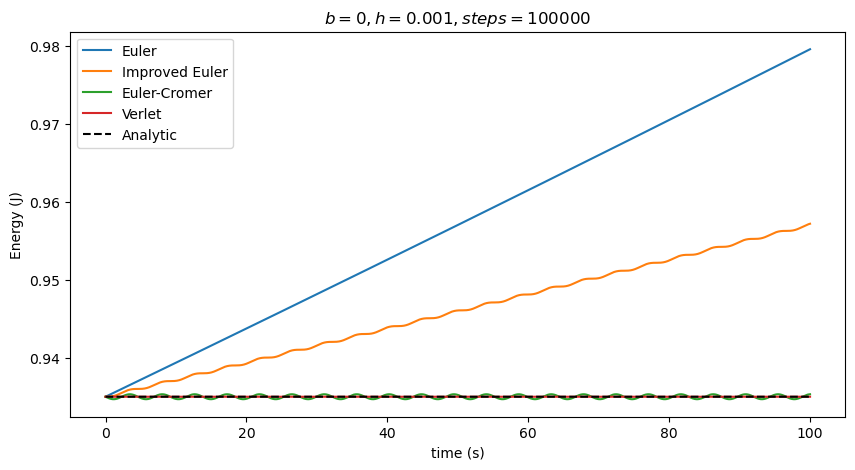

In [11]:
# Calculate energy for each method, setting b = 0.
energy_euler = energy(euler(variable_parameters=0))
energy_euler_improved = energy(improved_euler(variable_parameters=0))
energy_verlet = energy(verlet(variable_parameters=0))
energy_euler_cromer = energy(euler_cromer(variable_parameters=0))
energy_analytic = energy((analytic(TIME_ARRAY, variable_parameters=0)))

# Initialising axis and setting figure size.
fig, energy_axis = plt.subplots(1,1, figsize=(10,5))

# Plotting each energy.
euler_plot = energy_axis.plot(TIME_ARRAY, energy_euler, "-", label="Euler")
imp_euler_plot = energy_axis.plot(TIME_ARRAY, energy_euler_improved, "-", label="Improved Euler")
euler_cromer_plot = energy_axis.plot(TIME_ARRAY, energy_euler_cromer, "-", label="Euler-Cromer")
verlet_plot = energy_axis.plot(TIME_ARRAY, energy_verlet, "-", label="Verlet")
analytic_plot = energy_axis.plot(TIME_ARRAY, energy_analytic, "k--", label="Analytic")

# Setting axis labels & figures. 
energy_axis.set_xlabel("time (s)")
energy_axis.set_ylabel("Energy (J)")
energy_axis.set_title(rf"$b = {0}, h = {STEP}, steps = {STEPS}$")
energy_axis.legend()

# Displaying the plot
plt.show()

Simply by eye, we see that Euler-Cromer and Verlet describe the analytic energy the best. However, to get a clearer view as to which one is best, let's analyse the absolute difference between the analytic energy and the modelled energy.

In [12]:
energy_euler_delta = np.abs(energy_euler - energy_analytic)
energy_imp_euler_delta = np.abs(energy_euler_improved - energy_analytic)
energy_euler_cromer_delta = np.abs(energy_euler_cromer - energy_analytic)
energy_verlet_delta = np.abs(energy_verlet - energy_analytic)

Let us now plot this against time and see what it looks like.

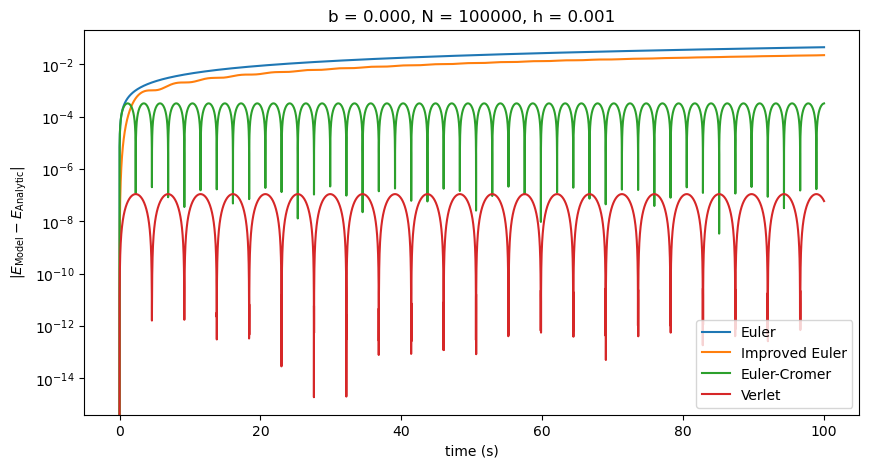

In [13]:
# Initialising axis and setting figure size.
fig, energy_delta_axis = plt.subplots(1,1, figsize=(10,5))

# Plotting energy difference against time.
euler_delta_energy_plot = energy_delta_axis.plot(TIME_ARRAY, energy_euler_delta, "-", label="Euler")
imp_euler_delta_energy_plot = energy_delta_axis.plot(TIME_ARRAY, energy_imp_euler_delta, "-", label="Improved Euler")
euler_cromer_delta_energy_plot = energy_delta_axis.plot(TIME_ARRAY, energy_euler_cromer_delta, "-", label="Euler-Cromer")
verlet_energy_delta_plot = energy_delta_axis.plot(TIME_ARRAY, energy_verlet_delta, "-", label="Verlet")

# Setting axis labels & figures.
energy_delta_axis.set_xlabel("time (s)")
energy_delta_axis.set_ylabel(r"$|E_{\text{Model}} - E_{\text{Analytic}}|$")
energy_delta_axis.set_yscale("log")
energy_delta_axis.set_title(rf"b = {0:.3f}, N = {STEPS}, h = {STEP}")
energy_delta_axis.legend()

# Displaying the plot
plt.show()

We can clearly see that the Verlet method leads to the lowest energy difference over time. This is a good initial indication that Verlet is the best numerical method to describe our problem. However, we still would like more evidence.

Let us now discuss potential errors in our numerical methods in more detail.

# Errors
We will discuss errors which can build up/occur while performing a numerical method due to the way computers work with numbers, and the nature of numerical methods. After considering what is discussed below, we will be in a good position to choose an appropriate numerical method for our system. 

## Truncation Error
Truncation errors come from approximating mathematical processes. If we return to the euler method, we said that the local truncation error was $\mathcal{O}(h^2)$. A local truncation error is the error caused by a single iteration. I.e., the difference between the analytic solution and the approximated solution will gain an error of order $h^2$ at each step. Numerical integration methods can also pick up global truncation errors from the cumulative error caused by many iterations. Thus, in order to minimise truncation error we must minimise step size, and choose a method with a truncation error of high order.

### Verlet Truncation Error
Verlet has a local truncation error of order $h^4$ in its displacement, the highest of all 4 numerical methods. This places it as a good candidate for our most optimal numerical method.

## Floating Point Error
Computers store decimals as floating point numbers, in a way akin to scientific notation in binary. Some decimal closed form numbers do not have a closed form in binary, which leads to a round-off error at low powers of 10. Python automaticall stores floating point numbers with double precision, allocating 8 bytes to the storing of numbers. This allows for a precision of up to $1 \times 10^{-16}$. Thus, we cannot really trust numbers which are under the order of $10^{-16}$. 

In this project, we work with numbers which do not tend to be of such a low order, so we do not need to worry about floating point errors appearing within our data. However, in physics we often deal with numbers of very low or very high orders. In order to alleviate errors which may occur due to floating points, we must simply choose appropriate units to describe our data. I.e., in a particle physics problem we are more likely to work with electron volts rather than joules, and in astrophysics we tend to work with solar masses rathere than kilograms.

## Discretisation and Floating Point Error
When we calculate a continuous function on a computer, it is actually represented by a finite number of evaluations. We can reduce the error we get from discretisation by making the step size small. In theory, the more arbitrarily small we make our time step, the better our numerical methods become. However, this is not the case due to floating point error. Eventually, with a small enough time step, our numerical methods gain a round off error, and start becoming less accurate the lower the time step becomes. We can find the optimal time step $h$ for a given approximation $F(x,h)$ of a function $f(x)$ by considering the time step which minimises the difference between the function and the approximation, i.e., the time step whcih minimises,

$$\Delta(h) = \left|f(x) - F(x,h)\right|.$$

The optimal time step depends on the given problem. I.e., for computing the first derivative, the optimal step size is $\sim1e-8$. Having an optimal time step which is high is often good, as it allows for finding the optimal solution to a given system over less steps, resulting in being less computationally expensive.

We will find the optimal time step for our given numerical methods.

In [14]:
def Delta(approximating_function, end_time, step_size):
    """
    Calculates the difference between the energy of a numerical approximation
    and the analytic solution, for a given time and step size.

    Parameters
    ----------
    approximating_function : function
        Numerical approximation function.
    end_time : float
        Time at which the numerical method terminates.
    step_size : float
        Step size for which the difference is calculates

    Returns
    -------
    np.abs(analytic - approx) : numpy array
        Array of the absolute difference between the energy of the analytic function
        and the approximation at each point.
    """
    # Number of steps for the simulation to run.
    steps = int(end_time/step_size)
    time_array = np.linspace(0,end_time,num=steps)

    analytic_energy = energy((analytic(time_array)))

    x, v = approximating_function(performance_parameters=(step_size,steps))
    approx_energy = energy((x,v))
    
    return np.abs(analytic_energy - approx_energy)

def get_delta(approx, min_h, max_h):
    """
    Obtains set of delta values for a range of step sizes.
    
    Parameters
    ----------
    approx : function
        Approximating function.
    min_h : integer
        Minimum order of range of step values.
    max_h : integer
        Maximum order of range of step values.

    Returns
    -------
    delta_array : numpy array
        Array of deltas for the range of step sizes.
    step_values : numpy array
        Array of step sizes corresponding to the tested step values.
    """
    # Create range of exponents to test.
    exponents = np.arange(min_h,max_h,dtype=float)
    step_values = np.concatenate([10**exponents, 
                                  (5)*10**(exponents-1), 
                                  (2.5)*10**(exponents-1), 
                                  (7.5)*10**(exponents-1)])
    
    delta_array = np.array([Delta(approx, 10**(exponents[-1]+1), h)[-2] for h in step_values])

    return delta_array, step_values

Now that we have written the appropriate functions, let us compute the deltas for each method. The exponent values were carefully chosen so that a minimum was observed, and to ensure that the program doesn't crash due to memory being overloaded, or the program receiving a number of steps $< 1$.

In [15]:
euler_delta, euler_steps = get_delta(euler, -10,-5)
optimal_step_euler = euler_steps[np.argmin(euler_delta)]

improved_euler_delta, improved_euler_steps = get_delta(improved_euler, -7,-3)
optimal_step_improved_euler = improved_euler_steps[np.argmin(improved_euler_delta)]

euler_cromer_delta, euler_cromer_steps = get_delta(euler_cromer, -10,-5)
optimal_step_euler_cromer = euler_cromer_steps[np.argmin(euler_cromer_delta)]

verlet_delta, verlet_steps = get_delta(verlet, -6,0)
optimal_step_verlet = verlet_steps[np.argmin(verlet_delta)]

Let us now plot each delta against step size.

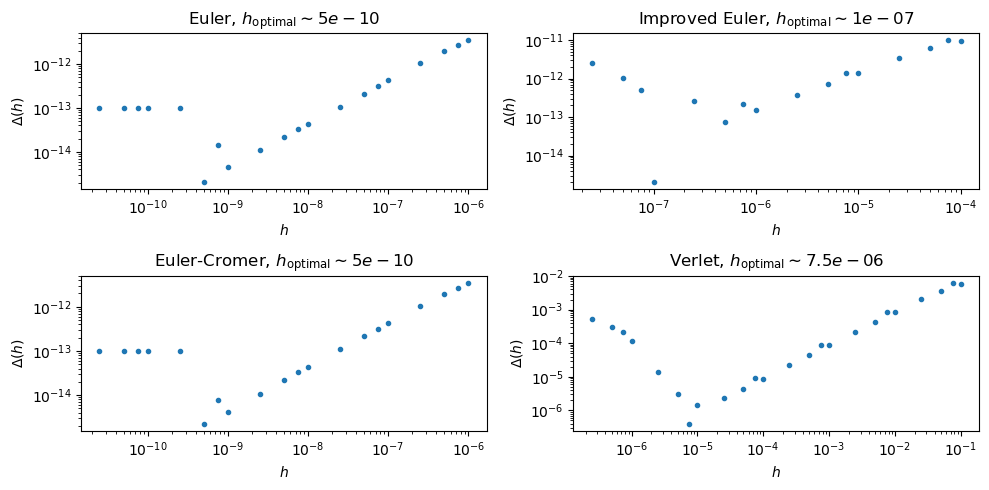

In [16]:
# Intialising figure and tweaking figure size.
fig = plt.figure(figsize=(10,5))

# Euler plots.
euler_ax=plt.subplot2grid((2,2), (0,0))
euler_dot, = euler_ax.plot(euler_steps, euler_delta, ".")
euler_ax.set_xscale("log")
euler_ax.set_yscale("log")
euler_ax.set_title(rf"Euler, $h_{{\text{{optimal}}}} \sim {optimal_step_euler}$")
euler_ax.set_ylabel(r"$\Delta(h)$")
euler_ax.set_xlabel("$h$")

# Improved Euler plots.
imp_euler_ax = plt.subplot2grid((2,2), (0,1))
imp_euler_dot, = imp_euler_ax.plot(improved_euler_steps, improved_euler_delta, ".")
imp_euler_ax.set_xscale("log")
imp_euler_ax.set_yscale("log")
imp_euler_ax.set_xlabel("$h$")
imp_euler_ax.set_title(rf"Improved Euler, $h_{{\text{{optimal}}}} \sim {optimal_step_improved_euler}$",y=1)
imp_euler_ax.set_ylabel(r"$\Delta(h)$")

# Verlet plots.
verlet_ax = plt.subplot2grid((2,2), (1,1))
verlet_dot, = verlet_ax.plot(verlet_steps, verlet_delta, ".")
verlet_ax.set_xscale("log")
verlet_ax.set_yscale("log")
verlet_ax.set_xlabel("$h$")
verlet_ax.set_title(rf"Verlet, $h_{{\text{{optimal}}}} \sim {optimal_step_verlet:.1e}$",y=1)
verlet_ax.set_ylabel(r"$\Delta(h)$")

# Euler-Cromer plots.
euler_cromer_ax = plt.subplot2grid((2,2), (1,0))
euler_cromer_dot, = euler_cromer_ax.plot(euler_cromer_steps, euler_cromer_delta, ".")
euler_cromer_ax.set_xscale("log")
euler_cromer_ax.set_yscale("log")
euler_cromer_ax.set_xlabel("$h$")
euler_cromer_ax.set_title(rf"Euler-Cromer, $h_{{\text{{optimal}}}} \sim {optimal_step_euler_cromer}$",y=1)
euler_cromer_ax.set_ylabel(r"$\Delta(h)$")

fig.tight_layout()
plt.show()

We see that for euler and euler cromer, the optimal time step is $\sim 10^{-10}$. For improved euler, although the detected minimal step is $\sim 10^{-7}$, this is past the turning point where we see more chaotic differences due to floating point error and round off - thus reading off the grpah, the optimal time step is $\sim 5\times 10^{-6}$. For the Verlet method, the optimal time step is $\sim 7.5e-6$. 

## Best Integration Method - Verlet
Verlet seems like the most optimal method to use for our problem, given its high order truncation error, its optimal time step, and its behaviour when analysing the energy of the system.

# Damping
We will analyse different values for the damping term $b$ with reference to the critical value. We have previously defined the criticla value. We will analyse the effects of,

- Light damping, $b = \frac{1}{2}b_{cr}$
- Critical damping, $b = b_{cr}$
- Overdamping, $b = {2}b_{cr}$

Below is an interactive plot where the slider can be used to control the coefficient of $b_{cr}$ which is applied to the system.

In [17]:
def crit_plotting(b):
    """
    Function for the interactive plot of the displacement of
    the oscillator, with a marker indicating when equilibrium is reached.

    Parameters
    ----------
    b : float
        Damping value coefficient.

    Returns
    -------
    None
    """
    # Calculate damping value.
    damping = (b * B_CRIT)

    # Change color of plot depending on type of damping.
    if b < 1:
        c = "tab:blue"
        lab = "Light damping"
    elif b == 1:
        c = "tab:orange"
        lab = "Critical Damping"
    else:
        c = "tab:green"
        lab = "Heavy damping"

    # Generate simulation data
    crit_x, crit_v = verlet(variable_parameters=damping)

    # Parameters for finding approximate equilibrium point
    equilibrium_threshold = 1e-7
    window_size = 10

    # Finds index of equilibrium point.
    equilibrium_indices = np.where((np.abs(crit_x) < equilibrium_threshold)
                                   & (np.abs(crit_v) < equilibrium_threshold))[0]

    # Check through all indices which satisfy equilbrium conditions
    for index in equilibrium_indices:
        # Check if all indices in the window satisfy equilibrium.
        if np.all(np.abs(crit_x[index:index+window_size]) < equilibrium_threshold) and np.all(np.abs(crit_v[index:index+window_size])  < equilibrium_threshold):
            equilibrium_time = TIME_ARRAY[index]
            break # Once equilibrium is found, end loop.

    # Initialise axis and figure, and tweak figure size.
    fig, crit_ax = plt.subplots(1, 1, figsize=(10, 5))
    
    # Plot data.
    crit_ax.plot(TIME_ARRAY, crit_x, "-", label=lab, color=c)
    crit_ax.axvline(x=equilibrium_time, linestyle="--", linewidth=1, color=c, label=f"Equilibrium Point, $t = {equilibrium_time:.2f}$")

    # Set figure and axis labels.
    crit_ax.set_xlabel("Time (s)")
    crit_ax.set_ylabel("Displacement (m)")
    crit_ax.set_title(f"$b = {b:.2f}b_{{cr}}, h = {STEP}$, Steps = ${STEPS}$")
    crit_ax.legend()
    plt.show()

# Begin interaction.
interact(crit_plotting, 
         b=FloatSlider(value=1,min=0.3, max=2, step=0.01))


interactive(children=(FloatSlider(value=1.0, description='b', max=2.0, min=0.3, step=0.01), Output()), _dom_cl…

<function __main__.crit_plotting(b)>

We see that the system completes a different number of oscillations for a given damping value, and varies in the amplitude of its displacement. Let's analyse this a bit further.

## Light Damping
The light damping case ($b = \frac{1}{2}b_{cr}$), we see almost a full oscillation, with the system having the greatest amplitude out of all damping scenarios. We find that the system returns to equilibrium at ~$46.06$ seconds with the parameters used.

## Critical Damping
In the critical damping case, we see no oscillations, and the system returning to equilibrium at ~$28.00$ seconds, the fastest of all 3 cases.

*NOTE:* When the damping value is $\lesssim b_{cr}$, the program finds the equilibrium point to be at a lower time than the critical damping value. This is not the expected result, and may be due to computational limits of the model or the way of finding equilibrium. However, this stops being a problem past $0.80b_{cr}$

## Overdamping
The overdamped oscillator ($b = 2b_{cr}$) has the lowest amplitude of oscillation, as well has returning to equilibrium the slowest, at ~$88.50$ seconds.

## Why is this?
Let's recall the general, analytic solution for the displacement of a damped harmonic oscillator and its angular frequency, and write it in exponential form,

\begin{align}
    x(t) = X_0 e^{-\frac{b}{2m}t}e^{i(\omega t + \phi)} && \omega = \sqrt{\frac{k}{m} - \left(\frac{b}{2m}\right)^2}.
\end{align}

where $\phi$ is a constant phase. 

- We see that in the case that in the critical damping case when $b = \sqrt{4km}$, $\omega = 0$, and thus the system does not complete any oscillations, and its displacement is purely decaying,

$$x(t) = X_0 e^{-\frac{\sqrt{km}}{m}t}e^{i\phi}.$$

- In the case that of light damping where $b < \sqrt{4km}$, we have that $\frac{k}{m} > \left(\frac{b}{2m}\right)^2$, thus the frequency is real and we retain oscillatory motion. The system eventually reaches equilibrium, but slower than in the critical damping case.
- In the case of heavy damping, we have that $b > \sqrt{4km}$, and $\omega$ becomes imaginary. We can then write, $$x(t) = X_0 e^{\left(-\frac{b}{2m} - \sqrt{\frac{b^2}{2m} - \frac{k}{m}}\right)t}e^{i\phi}.$$ We see that we do not retain any oscillations, just as in the critical damping case. However, comparing the damping terms we see that $-\left(\frac{b}{2m} + \sqrt{\frac{b^2}{2m} - \frac{k}{m}}\right) < -\frac{\sqrt{km}}{m}$, so the system undergoing heavy damping will fall into equilibrium much slower than the critically damped system.
  

# Applying Force
Let us now study the effect of applying a force to our system. We will consider the following,
- Sustained impulse over a a number of steps.
  - In the same direction to the instantaneous velocity.
  - At the opposite direction to the instantenous velocity.
- Sinusoidal force.

## Sustained impulse
Let us begin by applying a sustained impulse. In the interactive plot below, we can vary the time of the impulse, over how long it is applied, the amplitude of the force, and the damping of the system. 

In [23]:
def constant_force(time_of_force, force_length, b_coeff, amplitude):
    """
    Function to apply a constant force on the system.

    Parameters
    ----------
    time_of_force : int
        Time at which the force begins to act.
    force_length : float
        Amount of time in seconds for which the force is applied.
    b_coeff : float
        Damping factor coefficient.
    amplitude : float
        Amplitude of applied force.

    Returns
    -------
    verlet_with_constant_force : numpy array
        Simulation data with force in the direction of velocity.
    verlet_with_constant_opp_force : numpy array
        Simulation data with force in direction opposite velocity.
    x_verlet : numpy array
        Unforced simulation data.
    """
    # Simulation parameters.
    para = (b_coeff*B_CRIT)

    # Calculating unforced system.
    x_verlet, v_verlet = verlet(variable_parameters=para)
    
    # Changing force length from time to steps.
    steps_over_force = force_length/STEP

    # Where the force begins.
    index = int(time_of_force / STEP)
    # Initialising force array.
    constant_force = np.zeros(STEPS)

    # Populate force array up to the specified length.
    for i in range(index, np.min([index + int(steps_over_force), STEPS])):
        # Applying force in the direction of velocity
        constant_force[i] = amplitude*np.sign(v_verlet[index])

    # Force opposing the instantaneous velocity.
    opp_constant_force = -constant_force

    # Running the simulation with 
    verlet_with_constant_force, _ = verlet(force=constant_force, 
                                           variable_parameters=para)
    verlet_with_constant_opp_force, _ = verlet(force=opp_constant_force, 
                                               variable_parameters=para)

    return verlet_with_constant_force, verlet_with_constant_opp_force, x_verlet


def const_force_plotter(time_of_force, force_length, b_coeff, amplitude):
    """
    Function to allow for interactive plotting.

    Parameters
    ----------
    time_of_force : int
        Time at which the force begins to act.
    force_length : float
        Amount of time in seconds for which the force is applied.
    b_coeff : float
        Damping factor coefficient.
    amplitude : float
        Amplitude of applied force.

    Returns
    -------
    None
    """
    # Retrieve simulation data.
    forced, opposite_forced, x_verlet = constant_force(time_of_force, 
                                                       force_length, 
                                                       b_coeff,
                                                       amplitude)
    
    # Intialising figure and axis.
    fig, instant_force_axis = plt.subplots(1,1, figsize=(10,5))
    # Plotting unforced simulation.
    unforced = instant_force_axis.plot(TIME_ARRAY, x_verlet, "-", 
                                       label="Unforced Oscillations")
    # Plotting forced simulation.
    force_plot = instant_force_axis.plot(TIME_ARRAY, forced, "-", 
                                         label=f"Force in direction of velocity at $t = {time_of_force:.2f}$s")
    # Plotting simulation forced in opposing direction.
    opp_force_plot = instant_force_axis.plot(TIME_ARRAY, opposite_forced, "-", 
                                             label=f"Force in opposite direction to velocity at $t = {time_of_force:.2f}$s")
    
    # Setting figure and axis labels.
    instant_force_axis.set_xlabel("time (s)")
    instant_force_axis.set_ylabel("x (m)")
    instant_force_axis.annotate(f"Force applied for {force_length}s", xy=(80, -0.75))
    instant_force_axis.legend()
    instant_force_axis.set_title(f"b = {b_coeff:.1f}$B_{{cr}}$, N = {STEPS}, h = {STEP}")
    plt.show()

# Begin interaction.
interact(const_force_plotter, 
         time_of_force=IntSlider(value=49, min=1, max=TIME-1, description="Force Time"), 
         amplitude=FloatSlider(value=1, max=1, min=0, step=0.05, description="Amplitude (N)"), 
         force_length=FloatSlider(value=1, min=0.1, max=100, description="Force Length (s)"), 
         b_coeff=FloatSlider(value=0.1, min=0, max=2, step=0.1, description="$b$ coefficient."))

interactive(children=(IntSlider(value=49, description='Force Time', max=99, min=1), FloatSlider(value=1.0, des…

<function __main__.const_force_plotter(time_of_force, force_length, b_coeff, amplitude)>

Below are the observations from applying an impulse force:
- We see that applying a force to the system causes it to begin oscillating with a new amplitude, and with a slight shift to the equilibrium line.
- The forces causes the equilibrium line to shift below or above the unperturbed equilibrium line, depending on the direction of velocity. When the force stops begin applied, the system begins to oscillate about 0 again.
- For a great enough amplitude, or small enough unperturbed amplitude, the oscillations with a force applied in the direction of velocity match the peaks and troughs of the unperturbed amplitudes, while the oscillations with force applied in the direction opposite velocity have troughs corresponding to unperturbed peaks, etc.
- For small force amplitudes, the force opposing velocity matches the troughs and peaks of the unperturbed oscillations, but with a reduction in amplitude.
- In a critically damped system, the impulse causes the system to gain a boost for the length of the force, before making a rapid return to equilibrium. This also occurs for a heavily damped system, but the time it takes to return to equilibrium is much longer.

## Sinusoidal Forcing
We will now apply a sinusoidal force to the system. In the interactive plot below, we can vary the amplitude and frequency of the forcing.

In [19]:
def forced_sin(omega_coeff, amplitude, b):
    """
    Function to apply sinusoidal force to the system.

    Parameters
    ----------
    omega_coeff : float
        Coefficient which multiplies natural frequency of the oscillator
        to give the frequency of the driving force.
    amplitude : float
        Amplitude of the forcing.
    b : float
        Damping value.

    Returns
    -------
    None
    """
    # Calculating frequency. 
    omega = omega_coeff*NATURAL_FREQUENCY

    # Generating force.
    sin_force = amplitude*np.sin(omega*TIME_ARRAY)

    # Running simulations.
    x_verlet, _ = verlet(variable_parameters=b*B_CRIT)
    verlet_with_sin, _ = verlet(force=sin_force, variable_parameters=b*B_CRIT)
    
    # Initialising figures and axis.
    fig, sin_force_axis = plt.subplots(1,1, figsize=(10,5))

    # Plotting simulations.
    unforced = sin_force_axis.plot(TIME_ARRAY, x_verlet, "-", label="Unforced Oscillations")
    forced = sin_force_axis.plot(TIME_ARRAY, verlet_with_sin, "-", label=fr"Oscillations with forcing $F(t) = {amplitude}sin({omega_coeff}\omega_0 t)$")

    # Setting axis and figure labels.
    sin_force_axis.set_xlabel("time (s)")
    sin_force_axis.set_ylabel("x (m)")
    sin_force_axis.legend()
    sin_force_axis.set_title(f"b = {b*B_CRIT:.3f}, N = {STEPS}, h = {STEP}")
    plt.show()

# Begin interaction.
interact(forced_sin,  
         omega_coeff=FloatSlider(value=1, description=r'$\omega_0$ Coef.', max=2, min=0, step=0.1), 
         amplitude=FloatSlider(value=1, description=r'Amplitude', min=0, max=2, step=0.1),
         b = FloatSlider(value=0.1, description="$b$", min=0, max = 2, step=0.1))

interactive(children=(FloatSlider(value=1.0, description='$\\omega_0$ Coef.', max=2.0), FloatSlider(value=1.0,…

<function __main__.forced_sin(omega_coeff, amplitude, b)>

Below we discuss the observations in applying a sinusoildal force.

- As we vary the frequency, there is an initial randomness in the amplitude and frequency of the oscillations. After this period, the oscillations reach a steady state with constant frequency and amplitude.
- As the frequnecy is varied, the amplitude of oscillations varies.
    - Under light damping,
        - There is a value of forcing frequency just below the natural frequency of the oscillator where the amplitude of steady, forced oscillations reach a maximum amplitude.
        - Past this value, the amplitude  steady, forced oscillations decreases.
    - Under heavy and critical damping
        - The highest frequency is seen as $\omega \to 0$.
        - As the frequency is increased, the steady state amplitude decreases.

This increase in amplitude with change in frequency is known as *resonance*, and is discussed in more detail in the next section.

# Stretch: Resonance

To investigate resonance in the oscillator, we will plot steady state amplitudes over time for a range of frequencies (from $0\cdot\omega_0$ to $2\cdot\omega_0$) for $b = 0.1b_{cr}, 0.5b_{cr}$ and $b = b_{cr}$. Let us note that $\omega_0$ is the natural frequency of the oscillator, given by,

$$\omega_0 = \sqrt{\frac{k}{m}}.$$

In [20]:
# Start at 0.05 because program has trouble with b = b_cr at omega = 0
frequency_amplitude_range = np.linspace(0.01, 2, num=500)
def resonance(b_coeff):
    """
    Calculates steady state amplitude for given damping factor
    coefficient.

    Parameters
    ----------
    b_coeff : float
        Damping value coefficient.

    Returns
    -------
    maxima : numpy array
        Array of amplitudes for range of frequencies.
    maximum : float
        Maximum/resonant amplitude.
    resonant_frequency :float
        Resonant frequency.
    """

    # Performance parameters. 
    step = 1e-1
    time = 1000 # Allows for simulation to reach steady state.
    steps = int(time/step)
    per_para = (step, steps)
    time_array = np.linspace(0, time, num = steps)

    # Range of frequencies.
    forcing_frequencies = frequency_amplitude_range*NATURAL_FREQUENCY

    # Array with every frequency multiplied by the time array.
    omega_t = np.outer(forcing_frequencies, time_array)

    # Generate forcing.
    forcing_matrix = np.sin(omega_t)

    # Matrix of simulation data for every frequency.
    oscillator_matrix = np.array([verlet(force=forcing,
                                         performance_parameters=per_para,
                                         variable_parameters=b_coeff*B_CRIT)
                                  for forcing in forcing_matrix])

    # Initialise maxima array.
    maxima = np.zeros(500)

    # Enumerate over the oscillator matrix.
    for i, x in enumerate(oscillator_matrix[:,0]):
        # Populate with steady state amplitudes.
        maxima[i] = x[find_peaks(x)[0][-1]]

    # Calculate resonant amplitude and frequency.
    maximum = np.max(maxima)
    maximum_amplitude_index = np.argmax(maxima)
    resonant_frequency = frequency_amplitude_range[maximum_amplitude_index]
    
    return maxima, maximum, resonant_frequency

Let us now plot this for our previously stated values of $b$.

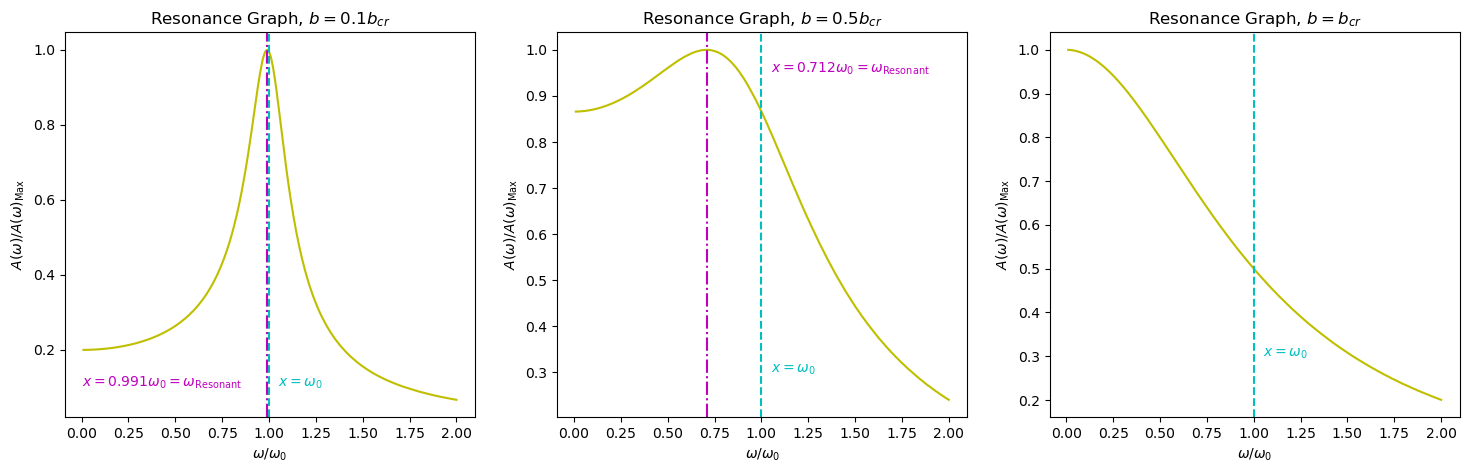

In [21]:
# Generate data.
maxima, maximum, resonant_frequency = resonance(0.1)
half_maxima, half_maximum, half_resonant_frequency = resonance(0.5)
crit_maxima, crit_maximum, crit_resonant_frequency = resonance(1)

# Initialise subplots and figure. 
fig, (resonance_axis, half_resonance_axis, crit_resonance_axis) = plt.subplots(1,3,figsize=(18,5))

# Plotting for b = 0.1b_cr
resonance_plot, = resonance_axis.plot(frequency_amplitude_range, maxima/maximum, "-", color='y')
omega_0 = resonance_axis.axvline(x=1, linestyle = '--', color='c')
resonant_omega = resonance_axis.axvline(x=resonant_frequency, linestyle = 'dashdot', color='m')
resonance_axis.annotate(r'$x = \omega_0$', xy=(1.05, 0.1), color="c")
resonance_axis.annotate(rf'$x = {resonant_frequency:.3f}\omega_0 = \omega_{{\mathrm{{Resonant}}}}$', xy = (0.0, 0.1), color='m')
# Setting axis labels. 
resonance_axis.set_xlabel(r"$\omega / \omega_0$")
resonance_axis.set_ylabel(r"$A(\omega)/A(\omega)_{\mathrm{Max}}$")
resonance_axis.set_title("Resonance Graph, $b = 0.1b_{cr}$")

# Plotting for b = 0.5b_cr
resonance_plot_half, = half_resonance_axis.plot(frequency_amplitude_range, half_maxima/half_maximum, "-", color='y')
half_omega_0 = half_resonance_axis.axvline(x=1, linestyle = '--', color='c')
half_resonant_omega = half_resonance_axis.axvline(x=half_resonant_frequency, linestyle = 'dashdot', color='m')
half_resonance_axis.text(1.05, 0.3,r'$x = \omega_0$', color="c")
half_resonance_axis.annotate(rf'$x = {half_resonant_frequency:.3f}\omega_0 = \omega_{{\mathrm{{Resonant}}}}$', xy = (1.05, 0.95), color='m')
# Setting axis labels.
half_resonance_axis.set_xlabel(r"$\omega / \omega_0$")
half_resonance_axis.set_ylabel(r"$A(\omega)/A(\omega)_{\mathrm{Max}}$")
half_resonance_axis.set_title("Resonance Graph, $b = 0.5b_{cr}$")

# Plotting for b = b_cr.
resonance_plot_crit, = crit_resonance_axis.plot(frequency_amplitude_range, crit_maxima/crit_maximum, "-", color='y')
crit_omega_0 = crit_resonance_axis.axvline(x=1, linestyle = '--', color='c')
crit_resonance_axis.text(1.05, 0.3,r'$x = \omega_0$', color="c")
# Setting axis labels. 
crit_resonance_axis.set_xlabel(r"$\omega / \omega_0$")
crit_resonance_axis.set_ylabel(r"$A(\omega)/A(\omega)_{\mathrm{Max}}$")
crit_resonance_axis.set_title("Resonance Graph, $b = b_{cr}$")

# Displaying the plot.
plt.show()

We see what we have observed before, as the oscillator approaches critical damping, its resonance peak shifts to the left. Furthermore, we see that the resonant frequency is always slightly before the natural frequency of the oscillator. The relation between the driving frequency and the amplitude of the oscillator is given by the formula,

$$A(\omega) = \frac{F_0/m}{\left((b/m)^2\omega^2 + (\omega_0^2 - \omega^2)^2\right)^{1/2}}$$

which is valid for when the oscillator reaches a steady state, i.e., once the entire system matches the frequency of the driving force. 